# Ensemble Model for Gender Using Traditional Methods

As opposed with the first two notebooks, this notebook will focus just on making a decent model to predict gender.  There will not be any exploration in this one, it is solely moving forward with creating a decently predictive model--although, there was **a lot** of exploration that happened behind the scenes in a scrap notebook to get to this point.  

I really enjoyed this particular dataset and target variable because it's been tough and difficult to get *anything* above 80% accuracy out of it.  I really felt like I was fighting for fractions of a percent and felt extremely proud when I'd manage to pull another percent out of it.  As is almost the standard for tough problems, this model is an ensemble which combines five other tuned models.  Stacking and blending models like this is a great way to break past asymptotic accuracy barriers that are reached using only single models.

This overall model was assembled using a logistic regression model, two different support vector classifiers, and two different gradient boosted decision trees.  Multiple methods of predicting the final output from the output of each individual classifier are used and compared at the end--with most getting within 0.5% accuracy of each other (however, like I said, I was fighting this data for crumbs so 0.5% is a lot to me).

![hello](https://media.giphy.com/media/Wj7lNjMNDxSmc/giphy.gif)

## Table of Contents
1. [Load and preprocess data](#data_load)
    - [Dealing with missing answers](#missing_vals)
    - [A little more data preparation](#more_prep)
    
+ [Building individual models](#models)
    - [Logarithmic Regression model](#logreg)
    - [Light Gradient Boosted Model (LGBM)](#lgbm)
    - [First Support Vector Classifier (SVC)](#svc1)
    - [Second Support Vector Classifier (SVC)](#svc2)
    - [XGBoost model](#xgb)
    
+ [Training the ensemble](#ensemble)
    - [Mean of predictions](#mean)
    - [Weighted mean of predictions](#weighted_mean)
    - [Mode of predictions](#mode)
    - [Logarithmic regression ensemble](#logensemble)
    - [SVC ensemble](#svcensemble)
    - [Decision tree ensemble](#treeensemble)
+ [Conclusions](#conclusions)

<a id="data_load"></a>
## Data loading and preprocessing

As usual, this first section simply installs any needed packages and imports any necessary packages, classes, and functions.  The data is loaded into a dataframe and all rows of data with missing or non-binary genders is removed. 

In [1]:
!pip install xgboost -q -q -q
!pip install 'scikit-learn==0.20.3' -q -q -q
!pip install lightgbm -q -q -q
!pip install scikit-optimize -q -q -q
!pip install numpy --upgrade -q -q -q
!pip install seaborn -q -q -q

Invalid requirement: ''scikit-learn==0.20.3''



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from skopt.space import Real, Integer, Categorical
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import pickle
import copy
import itertools
from scipy import stats
import random
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier

def pct(num):
    return int(round(num*10000))/100.00

%matplotlib inline

#sklearn kind of sucks and puts out a lot of metric warnings--especially when you have an extreme minority class that may
#not get predicted.
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

df = pd.read_csv('data_trans.csv', encoding='utf-8')
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,gender,accuracy,country,source,elapsed,sqrtbox_age,box_accuracy,box_elapsed,bin_age,bin_country
0,1,4,2,3,3,2,3,4,4,3,...,1,92,US,5,914,1.683215,2.270186,9.774004,0,US
1,4,3,4,3,4,4,4,4,2,2,...,1,100,US,0,891,1.900242,2.287068,9.723672,4,US
2,3,4,4,4,4,4,4,3,2,2,...,1,80,US,5,903,1.853102,2.240760,9.750076,3,US
3,4,5,4,4,4,3,3,2,2,2,...,1,93,US,0,806,1.861649,2.272403,9.526909,3,US
4,4,0,4,4,4,3,5,1,2,4,...,2,87,NZ,0,1826,1.956691,2.258593,11.190933,4,Other


In [3]:
df.gender.value_counts(dropna=False)
og_count = df.shape[0]
df = df[df.gender!=0]

non_features = ['age', 'accuracy', 'elapsed', 'gender', 'source', 'country',
               'sqrtbox_age', 'box_accuracy', 'box_elapsed', 'bin_age', 'bin_country']

# create a copy dataset but drop all non-binary genders (which makes it a binary classification problem)
# re-code binary variables to be 0/1 instead of 1/2
X = df.drop(non_features, axis=1)
y = df.gender
X = X[y>0]
y = y[y>0]
X = X[y<3]
y = y[y<3]
y = y-1

<a id="missing_vals"></a>
### Dealing with missing data

First things first, we must deal with missing data.  Below is a distribution plot for how many rows are missing values for all of the columns.  Considering there is almost 40k rows of data total, each column missing a few hundred values doesn't seem to be that significant.

/home/ubuntu/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


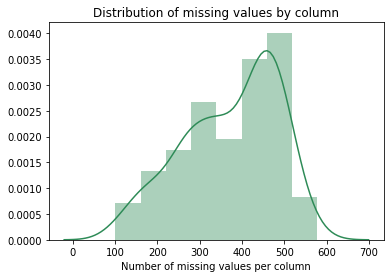

In [4]:
sns.distplot([X[col].value_counts()[0] for col in X.columns], color='seagreen')
plt.xlabel("Number of missing values per column")
plt.title("Distribution of missing values by column");

In [5]:
# the below function counts the number of missing values in each row
def missing_count(row, missing_val=0):
    vals = set(row.unique())
    if 0 in vals: vals.remove(0)
    else: return 0
    flatten_dict = {x:0 for x in vals}
    flatten_dict[0] = 1
    return row.replace(flatten_dict).sum()

has_zeros = X.apply(missing_count, axis=1)
zero_count = has_zeros.value_counts()
print(f"{pct(len(X)-zero_count[0])/len(has_zeros)}% of the rows have at least one missing question in the dataset.")
print(f"There are {zero_count[0]} rows of data with no missing questions.")

27.70907132351418% of the rows have at least one missing question in the dataset.
There are 34897 rows of data with no missing questions.


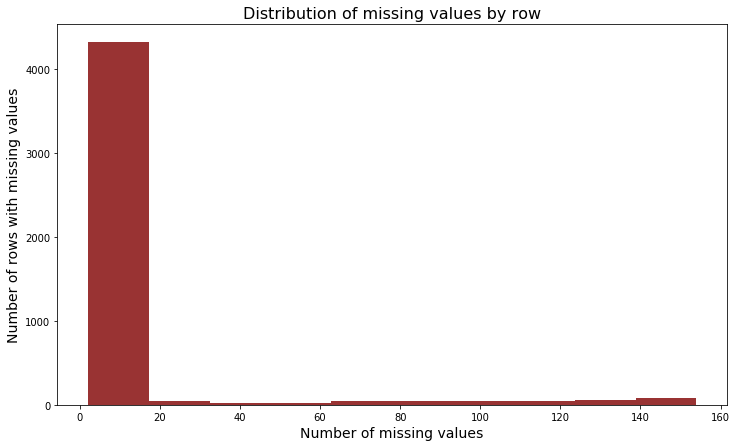

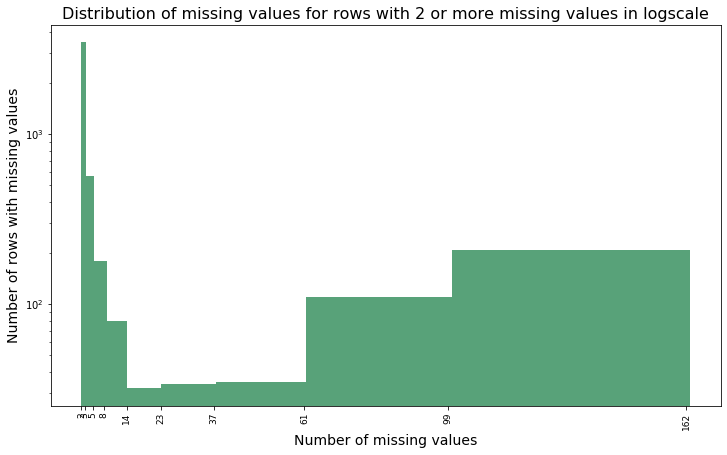

In [6]:
plt.figure(figsize=(12, 7))
plt.hist(has_zeros[has_zeros>1], color='maroon', alpha=0.8)
plt.title("Distribution of missing values by row", fontsize=16)
plt.xlabel("Number of missing values", fontsize=14)
plt.ylabel("Number of rows with missing values", fontsize=14)
plt.show()

bins = np.geomspace(2, 163, 10)
int_bins = [int(i) for i in bins]
plt.figure(figsize=(12, 7))
plt.hist(has_zeros, bins=bins, color='seagreen', alpha=0.8)
plt.title("Distribution of missing values for rows with 2 or more missing values in logscale", fontsize=16)
plt.xlabel("Number of missing values", fontsize=14)
plt.ylabel("Number of rows with missing values", fontsize=14)
plt.xticks(int_bins, rotation=90, fontsize=9)
plt.yscale('log');

#### Removing the missing data

Clearly, the vast majority of rows of data are missing only one value or less.  My first instinct was to drop all rows that were missing more than one answer but, through experimentation with the data, I realized that dropping all rows of data gives--by far--the best performance boost over almost every alternate method (from specially encoding missing values to using complex imputation techniques).  For this reason, I end up setting the cut-off level for removing a row to be *any* missing answers.

In [7]:
cut_off = 0
X_drop = X[has_zeros<=cut_off]
y_drop = y[has_zeros<=cut_off]
print(f"The data has {len(X_drop)} rows with {cut_off} or fewer missing answers.")

The data has 34897 rows with 0 or fewer missing answers.


<a id="more_prep"></a>
### A little more data preparation

This section is a quick section to prep the data before training.  The class defined in the next block transforms our ordinal variables into a decent form for use with logistic regression.  This is an encoding method I developed on my own with which I've noticed consistent better performance with ordinal variables on logistic regression (and neural networks--but that's a later notebook).  This method works similar to one-hot encoding, but instead of all columns being zero except for the category we want to represent, the ordinal category we wish to represent and all categories less than it are encoded with a one and all higher ordinal categories are zero.  There are solid mathematical reasons why this works by allowing the process of minimizing the loss function of our logistic regression system to encode the optimal distance between each ordinal variable--but that is also another notebook.  I plan on doing a workthrough notebook and a short write-up on the method and uploading it to my GitHub at some point in the future.

As a quick example, if the column being transformed can be missing values (0) or one of two ordinals (1 or 2), the encoder will transform each as follows:

        0  ->  [0, 0]
        1  ->  [1, 0]
        2  ->  [1, 1]

After the encoding class is defined, the data is split into a training, validation, and testing set and an ordinal dummy encoding done on a copy of each.  I am using a three-way split so that the individual models can be tuned using crossvalidation and resampling techniques on just the training set and then the ensemble model will be trained on the validation set.  Training the ensemble on a different set than the individual models is necessary to avoid serious data leakage. Training and tuning the ensemble model on the same training set that the individual models were trained was estimating my final accuracy to be nearly 100% but only giving me 79 - 80% on the actual test data.

In [8]:
class OrdinalDummyEncoder:
    
    def __init__(self, impute_missing=None):
        # impute_missing is a simple variable that lets you impute the mean or mode into missing values as
        # it encodes each column
        # using "mean" gives an interesting result because it encodes missing values as the expected value of the variable
        self.impute_missing = impute_missing
    
    def fit(self, X, y):
        # added to be compatible with scikit-learn encoders.  Unused because nothing needs to be fit.
        pass
    
    def fit_transform(self, X, cols=None, verbose=False):
        # added to be compatible with scikit-learn encoders.  Just transforms because nothing needs to be fit.
        return self.transform(X, cols=cols, verbose=verbose)
    
    def transform(self, X_vals, cols=None, verbose=False):
        # transforms the the df to ordinal dummy encoded variables as described above
        # if cols=None, transform every column.  Else, transform the columns with names in 'cols'
        X = X_vals.copy()
        first_col = True
        if cols: columns=cols
        else: columns=X.columns
        for col in tqdm_notebook(columns, disable=(not verbose)):
            trans_col = self.__column_transformer(X[col])
            if first_col:
                new_df = trans_col
                first_col=False
            else:
                new_df = pd.concat([new_df, trans_col], axis=1)
        return new_df
    
    def __column_transformer(self, column):
        # encodes a single column
        if 0 in column.unique():
            num_new_cols = len(column.unique())
        else:
            num_new_cols = len(column.unique())+1
        col_length = len(column)
        new_col_array = np.zeros((col_length, num_new_cols-1), dtype=int)
        row_count=0
        indexes = []
        for index, row in column.iteritems():
            col_index = row-1
            if col_index>=0:
                num_last_zs = num_new_cols-row
                encoded = [1]*row + [0]*(num_last_zs-1)
                new_col_array[row_count] = encoded
            row_count+=1
            indexes.append(index)
        returned = pd.DataFrame(new_col_array, columns=[column.name+'_'+str(i) for i in range(1,num_new_cols)], index=indexes)
        if self.impute_missing=="mean" or self.impute_missing=="mode":
            for col in returned:
                if self.impute_missing=="mean":
                    returned[col][column==0] = returned[col].mean()
                elif self.impute_missing=="mode":
                    returned[column==0] = returned[col].mode()
        return returned

In [9]:
X_train, X_, y_train, y_ = train_test_split(X_drop, y_drop, test_size=0.7, stratify=y_drop, random_state=12)
X_test, X_val, y_test, y_val = train_test_split(X_, y_, test_size=0.66, stratify=y_, random_state=36)

ord_encoder = OrdinalDummyEncoder()
X_train_ord = ord_encoder.transform(X_train)
X_test_ord = ord_encoder.transform(X_test)
X_val_ord = ord_encoder.transform(X_val)

The below block just gives me a simple method to save the exact data splits and models so that I could experiment with the final ensemble on my laptop and save some of my precious free AWS time.  It will also help in a future notebook where I plan on using an ensemble that combines these traditional models with deep learning techniques.  Keeping the same exact models and data splits will allow me to make direct comparisons between methods in future notebooks.

In [10]:
def save_pickle(obj, name, file_type=None):
    if file_type is None:
        file_type = ".data"
    file = open(name+file_type, 'wb')
    pickle.dump(obj, file)
    file.close()

def load_pickle(name):
    file = open(name, 'rb')
    r = pickle.load(file)
    file.close()
    return r

save_pickle(X_train, "X_train")
save_pickle(X_test, "X_test")
save_pickle(X_val, "X_val")
save_pickle(X_train_ord, "X_train_ord")
save_pickle(X_test_ord, "X_test_ord")
save_pickle(X_val_ord, "X_val_ord")
save_pickle(y_train, "y_train")
save_pickle(y_test, "y_test")
save_pickle(y_val, "y_val")

<a id="models"></a>
## Building individual models

Now starts the fun part.  Five different models will be created a tuned.  The goal is to get each individual model to at least 80% so that no single model drags down the overall accuracy of the ensemble.  Granted, a second key component is having models that misclassify differently and don't all behave exactly the same--a big reason I went with two separate SVCs (one polynomial kernel and one radial basis function kernel) to help ensure decision boundaries are distinct between the models.

<a id="logreg"></a>
### Logarithmic Regression

The first model trained is my personal favorite method.  I **looooove** logistic regression for it's speed, ease-of-use, reliability, and it's naturally calibrated probabilities.  I could've simply used scikit-learn's LogisticRegressionCV and saved some time on the following grid search but I wanted to be absolutely confident that there wasn't a better model sitting out there with a different loss function or balanced weights.

In [11]:
base_C = np.logspace(-5, 5, 50)
param_grid = {'C': base_C, 'penalty': ['l1', 'l2'], 'class_weight': [None, 'balanced']}
logreg_seed = 13
grid = GridSearchCV(LogisticRegression(random_state=logreg_seed, max_iter=300), param_grid, cv=5, n_jobs=-1)
grid.fit(X_train_ord, y_train)
log_best_params = grid.best_params_
print("Best hyperparameters found: "+str(log_best_params))
print(f"Best resample accuracy: {pct(grid.best_score_)}%")

Best hyperparameters found: {'C': 0.011513953993264481, 'class_weight': None, 'penalty': 'l2'}
Best resample accuracy: 81.03%


In [12]:
log_model = LogisticRegression(**log_best_params, random_state=logreg_seed, n_jobs=-1)
log_model.fit(X_train_ord, y_train)
y_test_preds = log_model.predict(X_test_ord)
print(f"Overall accuracy of best model found: {pct(accuracy_score(y_test, y_test_preds))}")
save_pickle(log_model, "log_model")

Overall accuracy of best model found: 81.55


#### Hyperparameter tuning with resampling

The following class is a quick draft of a full class (well, group of classes) I've made to tune hyperparameters using resampling techniques instead of k-fold crossvalidation.  While resampling tends to underestimate accuracy compared to crossvalidation, it does so *consistently*--a trait which still makes it valuable for hyperparameter tuning.  Specific hyperparameters that maximize crossvalidation accuracy should--in most situations--also maximize accuracy estimated by training and evaluating the model on a large group of samples.  The benefit to this is that hyperparameter tuning using resampling tends to be much faster as each model can be trained on a much smaller sample than each fold is in crossvalidation.

If you'd like to see the full implementation of the following randomized search with resampling class as well it's little brother grid search with resampling, you can look into it further on my GitHub [here](https://github.com/metriczulu/tuneRs).

In [13]:
class RandomSearchResample:
    
    def __init__(self, model, params, num_iter=60, num_samples=10, sample_size=0.2, test_size=0.3, metric=None, 
                 random_state=None):
        '''
        param model:        The model to tune
        param params:       A parameter dictionary.  Uses the scikit-optimize variables skopt.Integer, skopt.Categorical, and 
                            skopt.Real
        param num_iter:     Number of random variables to try
        param num_samples:  The total number of samples and models trained for each parameter
        param sample_size:  The size of samples taken.  Any percentage in (0, 1]
        param test_size:    Size of the test size in each sample
        param metric:       Scoring metric to evaluate each model.  Defaults to simple accuracy if None
        param random_state: Self-explanatory
        '''
        self.metric = metric
        self.num_samples = num_samples
        self.sample_size = sample_size
        self.test_size = test_size
        self.best_params_ = None
        self.model = model
        if random_state is None:
            random_state = np.random.randint(0, 36000)
        self.random_state = random_state
        self.num_iter = num_iter
        self.best_score_ = 0.0
        self.best_model = None
        self.best_std_ = 0.0
        self.params=params
        self.param_grid = self.__random_grid(self.random_state+13)
        
    def __random_grid(self, random_state=None):
        # Generates a list of random hyperparameter dictionaries to iterate over
        if random_state==None:
            random_state = np.random.randint(0, 36000)
        np.random.seed(random_state)
        random_list = np.random.randint(0, 36000, size=self.num_iter)
        param_list = []
        for index in range(self.num_iter):
            param_list.append({key: self.params[key].rvs(1, random_state=random_list[index])[0] for key in self.params})
        return param_list
        
    def __resample_eval(self, model, X, y, verbose=False):
        '''
        Evaluates the model on a given set
        
        param model:   model to evaluate
        param X:       Training data
        param y:       Labels
        param verbose: True to generate tqdm bar
        '''
        np.random.seed(self.random_state)
        random_list = np.random.randint(0, 36000, size=self.num_samples)
        if self.metric is None:
            metric = accuracy_score  
        sample_scores = []
        for sample_ndx in tqdm_notebook(range(self.num_samples), disable=(not verbose)):
            X_sample, _, y_sample, _ = train_test_split(X, y, train_size=self.sample_size, stratify=y, 
                                                        random_state=random_list[sample_ndx]+13)
            X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=self.test_size, 
                                                                stratify=y_sample, random_state=random_list[sample_ndx])
            clf = model.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            sample_scores.append(metric(y_test, y_pred))            
        mean = np.mean(sample_scores)
        std = np.std(sample_scores)
        return mean, std
        
    def fit(self, X, y, verbose=False):
        '''
        Finds the optimal hyperparameter
        
        param X:       Training data
        param y:       Labels
        param verbose: True to generate tqdm bar
        '''
        for random_param in tqdm_notebook(self.param_grid, disable=(not verbose)):
            self.model.set_params(**random_param)
            score, std = self.__resample_eval(self.model, X, y)
            if score>self.best_score_:
                self.best_params_ = random_param
                self.best_score_ = score
                self.best_std_ = std
                self.best_model = copy.copy(self.model)

<a id="lgbm"></a>
### Light Gradient Boosted Model (LGBM classifier)

Not exactly related to this notebook, just want to throw it out there that LGBM is--by far--one of my favorite packages to use and the best implementation of gradient boosted tree ensembles in the world.

In [14]:
param_space = {'max_depth': Integer(1, 32), 
              'loss_function': Categorical(['Logloss', 'CrossEntropy']), 
              'num_leaves': Integer(2, 150),
              'learning_rate': Real(.001, 0.5),
              'n_estimators': Integer(100, 3000),
              'max_bin': Integer(2, 12),
              'boosting_type': Categorical(['gbdt', 'dart', 'goss'])}
lgbm_seed = 7
grid = RandomSearchResample(LGBMClassifier(random_state=lgbm_seed, n_jobs=-1), params=param_space, 
                            num_iter=120, num_samples=20, random_state=396)
grid.fit(X_train, y_train)
lgbm_best_params = grid.best_params_
print("Best hyperparameters found: "+str(lgbm_best_params))
print(f"Best resample accuracy: {pct(grid.best_score_)}%")

Best hyperparameters found: {'max_depth': 16, 'loss_function': 'CrossEntropy', 'num_leaves': 118, 'learning_rate': 0.3082744216762507, 'n_estimators': 2355, 'max_bin': 6, 'boosting_type': 'dart'}
Best resample accuracy: 79.0%


In [15]:
lgbm_model = LGBMClassifier(**lgbm_best_params, random_state=lgbm_seed, n_jobs=-1)
lgbm_model.fit(X_train, y_train)
y_test_preds = lgbm_model.predict(X_test)
print(f"Overall accuracy of best model found: {pct(accuracy_score(y_test, y_test_preds))}")
save_pickle(lgbm_model, "lgbm_model")

Overall accuracy of best model found: 81.63


<a id="svc1"></a>
### First Support Vector Classifier (SVC)

This first SVC is made using a radial basis function (RBF) kernel and tuned using a simple grid search.

In [16]:
param_space = {'C':[0.01, 0.1, 1, 10, 100],
              'gamma': [0.0001, 0.001, 0.01, 0.1, 1]}

svc1_seed = 42
grid = GridSearchCV(SVC(kernel='rbf', random_state=svc1_seed), param_space, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)
svc1_best_params = grid.best_params_
print("Best hyperparameters found: "+str(svc1_best_params))
print(f"Best resample accuracy: {pct(grid.best_score_)}%")

Best hyperparameters found: {'C': 10, 'gamma': 0.001}
Best resample accuracy: 80.42%


In [17]:
svc1_model = SVC(kernel='rbf', **svc1_best_params, probability=True, random_state=svc1_seed)
svc1_model.fit(X_train, y_train)
y_test_preds = svc1_model.predict(X_test)
print(f"Overall accuracy of best model found: {pct(accuracy_score(y_test, y_test_preds))}")
save_pickle(svc1_model, "svc1_model")

Overall accuracy of best model found: 81.82


<a id="svc2"></a>
### Second Support Vector Classifier (SVC)

This second SVC uses a polynomial kernel.  As we will be search over multiple polynomial degrees and training two and three degree polynomial kernels takes a long long time, the randomized search with resampling class will be used.

In [18]:
param_space = {'degree': Integer(2, 3),
               'C': Real(0.001, 1000, prior="log-uniform"),
               'gamma': Real(0.0001, 100, prior="log-uniform")}
svc2_seed = 37
grid = RandomSearchResample(SVC(kernel='poly', random_state=svc2_seed), params=param_space, 
                            num_iter=120, num_samples=20, random_state=19)
grid.fit(X_train, y_train)
svc2_best_params = grid.best_params_
print("Best hyperparameters found: "+str(svc2_best_params))
print(f"Best resample accuracy: {pct(grid.best_score_)}%")

Best hyperparameters found: {'degree': 3, 'C': 0.025749617515621524, 'gamma': 0.0025749617515621525}
Best resample accuracy: 78.44%


In [19]:
svc2_model = SVC(kernel='poly', **svc2_best_params, probability=True, random_state=svc2_seed)
svc2_model.fit(X_train, y_train)
y_test_preds = svc2_model.predict(X_test)
print(f"Overall accuracy of best model found: {pct(accuracy_score(y_test, y_test_preds))}")
save_pickle(svc2_model, "svc2_model")

Overall accuracy of best model found: 81.57


<a id="xgb"></a>
### XGBoost Classifier

XGBoost seems to be the most popular gradient boosted tree ensemble library and for good reason.  It works.  I also considered using CatBoost as a classifier but the large number of categorical features in this data caused it to take waaaaay longer to train--even using resampling instead of crossvalidation.

In [20]:
param_space = {'max_depth':Integer(2, 32), 
              'booster': Categorical(['gbtree', 'dart']), 
              'min_child_weight': Integer(1, 8),
              'learning_rate': Real(0.001, 0.5),
              'n_estimators': Integer(50, 3000),
              'gamma': Real(0.001, 100, prior="log-uniform"),
              'colsample_bytree': Real(0.01, 1)}

xgb_seed = 123
grid = RandomSearchResample(XGBClassifier(verbosity=0, random_state=xgb_seed, n_jobs=-1), params=param_space, 
                            num_iter=120, num_samples=20, random_state=21)
grid.fit(X_train, y_train)
xgb_best_params = grid.best_params_
print("Best hyperparameters found: "+str(xgb_best_params))
print(f"Best resample accuracy: {pct(grid.best_score_)}%")

Best hyperparameters found: {'max_depth': 6, 'booster': 'gbtree', 'min_child_weight': 5, 'learning_rate': 0.06787839616843971, 'n_estimators': 982, 'gamma': 0.004678689346971979, 'colsample_bytree': 0.14268459360071206}
Best resample accuracy: 78.92%


In [21]:
xgb_model = XGBClassifier(verbosity=0, random_state=xgb_seed, n_jobs=-1, **xgb_best_params)
xgb_model.fit(X_train, y_train)
y_test_preds = xgb_model.predict(X_test)
print(f"Overall accuracy of best model found: {pct(accuracy_score(y_test, y_test_preds))}")
save_pickle(xgb_model, "xgb_model")

Overall accuracy of best model found: 81.84


<a id="ensemble"></a>
## Training the ensemble model

The class below allows me to combine the previous models together and train a new model to predict outcomes from the individual predictions.  This class is pretty large for a notebook and provides functionality to combine predictions by taking weighted averages of probabilities, taking the mode of predictions, and training an actual model to predict.  Rather than take the actual predictions of each model and combine them into an overall prediction, this class takes the *predicted probabilites* of each model and uses those probabilities to predict a label.

In [22]:
class PretrainedCatEnsemble:
    def __init__(self, model_list, ensemble_model=None, weights=None, use_probs=True):
        '''
        Builds an ensemble model
        
        param model_list:     a list of the models to be used
        param ensemble_model: the model used to combine predictions.  If None, defaults to logistic regression
        param weights:        Weights to define importance of each model.  Defaults to one for each model
        param use_probs:      True to use predicted probabilities to train ensemble model.  False to use
                              actual predictions instead.
        '''
        if ensemble_model is None:
            from sklearn.linear_model import LogisticRegression
            self.ensemble_model = LogisticRegression()
        else:
            self.ensemble_model = ensemble_model
        self.num_models = len(model_list)
        self.model_list = model_list
        self.num_labels = 1
        self.use_probs = use_probs
        self.optimal_params = dict()
        self.stored_probs = None
        self.stored_y = None
        self.stored_test_probs = None
        self.stored_test_y = None
        self.stored_test = False
        self.base_weights = np.array([1.0]*self.num_models)
        self.max_weights = np.array([1.0]*self.num_models)
        if weights is None:
            self.weights = np.array([1.0]*self.num_models)
        else:
            self.weights = np.array(weights)

    def set_data(self, X_train=None, y_train=None, X_test=None, y_test=None, weighted=False, verbose=False):
        '''
        Stores the main data splits used.  Done to save time on by only calculating predicted probabilities for both
        once instead of every time.
        
        param X_train:   Training data
        param y_train:   Training labels
        param X_test:    Testing data
        param y_test:    Testing labels
        param weighted:  If True, use weighting scheme
        '''
        if X_train is not None:
            self.stored_probs = self.__prob_array(X_train, weighted=weighted, verbose=verbose)
        if X_test is not None:
            self.stored_test = True
            self.stored_test_probs = self.__prob_array(X_test, weighted=weighted, verbose=verbose)
        if y_test is not None:
            self.stored_test_y = y_test
        if y_train is not None:
            self.stored_y = y_train
    
    def set_weights(self, weights="base"):
        '''
        Change importance weights
        
        param weights:  "base" to equally weight each model.  "max" to use generated maximal weigts.  Any other set
                         input will be used as the weights directly.
        '''
        if weights=="base":
            self.weights = self.base_weights
        elif weights=="max":
            self.weights = self.max_weights
        else:
            self.weights = weights

    def change_ensemble_method(self, ensemble_model, weighted=False):
        '''
        Change the model used to predict outcomes from other models
        
        param ensemble_model:  New ensemble method to use
        weighted:              If True, use weights to specify importance
        
        Returns: Predictions of model on training data
        '''
        self.ensemble_model = ensemble_model
        if weighted:
            X = self.stored_probs*self.weights
        else:
            X = self.stored_probs
        self.ensemble_model.fit(X, self.stored_y)
        return self.ensemble_model.predict(X)
    
    def tune_hyperparameters(self, hyperparameters, num_samples=5, method="bayes", n_iter=60, 
                             n_jobs=-1, sample_size=0.2, test_size=0.3, verbose=0, random_state=None, train_final=True, 
                             return_accuracy=False, return_search=False, weighted=False):
        '''
        Automatically tunes hyperparameters for ensemble model
        
        param hyperparameters:     Hyperparameter grid to use
        param num_samples:         Number of samples or crossvalidation folds to use
        param method:              "bayes" for Bayesian optimization.  "grid" for cv grid search. "random" for 
                                    cv randomized search.  "random-resample" for resampled randomized search
        param n_iter:              Number of iterations to use for Bayes or randomized methods
        param n_jobs:              Number of cores to use
        param sample_size:         Sample size for resample methods
        param test_size:           Test set size in resamples
        param verbose:             Verbosity of search.  Higher integers return more status.  Does not work with random-resample
        param train_final:         If true, train ensemble model on optimal hyperparameters
        param return_accuracy:     Return accuracy with parameters if True
        param return_search:       If true, return the actual search model.  Can be used with random-resample to plot
                                   distribution of sample accuracy if using full class found in GitHub link further up
        param weighted:            If True, uses weighted predicted probabilities
        
        Returns:                   Some combination of best params, best score, and the search function itself
        '''
        if method=="bayes":
            grid = BayesSearchCV(self.ensemble_model, hyperparameters, cv=num_samples, n_iter=n_iter, 
                                 verbose=verbose, n_jobs=n_jobs, random_state=random_state)
        elif method=="grid":
            grid = GridSearchCV(self.ensemble_model, hyperparameters, cv=num_samples, 
                                verbose=verbose, n_jobs=n_jobs)
        elif method=="random":
            grid = RandomizedSearchCV(self.ensemble_model, hyperparameters, cv=num_samples, n_iter=n_iter, 
                                      verbose=verbose, n_jobs=n_jobs, random_state=random_state)
        elif method=="random-resample":
            grid = RandomSearchResample(self.ensemble_model, params=hyperparameters, num_iter=n_iter, sample_size=sample_size,
                                        num_samples=num_samples, test_size=test_size, random_state=random_state)
        X = self.__prob_array(X="train", weighted=weighted)
        grid.fit(X, self.stored_y)
        if train_final:
            model = self.ensemble_model.set_params(**grid.best_params_)
            model.fit(X, self.stored_y)
        self.optimal_params = grid.best_params_
        self.ensemble_model.set_params(**self.optimal_params)
        if return_accuracy:
            if return_search:
                return grid.best_params_, grid.best_score_, grid
            else:
                return grid.best_params_, grid.best_score_
        else:
            if return_search:
                 return grid.best_params_, grid
            else:
                return grid.best_params_

    def maximize_weights(self, weight_grid=None, method="random", set_weights=True, n_iter=1500, 
                         return_acc=True, random_state=None, verbose=False):
        '''
        Find weights which maximize accuracy of training data
        
        param weight_grid:   List of list of weights to search combinations of
        param set_weights:   Set maximal weights found for future use
        param n_iter:        Number of weight combinations to try
        param method:        "random" to check random weights.  Anything else and a grid search is performed
        param return_acc:    Return the best accuracy found
        
        Returns:  Maximal weighting found and maximum accuracy found (if return_acc=True)
        '''
        max_acc = 0.0
        max_acc_weights = []
        X = self.__prob_array(X="train")
        y = self.stored_y
        if weight_grid is None:
            simple_grid = np.arange(start=0.0, stop=1.01, step=0.05)
            weight_grid = [simple_grid for _ in range(self.num_models)]
        weight_grid = itertools.product(*weight_grid)
        if method=="random":
            random.seed(random_state)
            weight_grid = random.sample(list(weight_grid), n_iter)
        for weights in tqdm_notebook(weight_grid, disable=(not verbose)):
            acc = accuracy_score(y, self.mean(X=X, weights=list(weights), need_prob_array=False))
            if acc>max_acc:
                max_acc = acc
                max_acc_weights = weights
        self.max_weights = weights
        if set_weights:
            self.weights = max_acc_weights
        if return_acc:
            return self.max_weights, max_acc
        else:
            return self.max_weights

    def mean(self, X="train", weights="base", need_prob_array=True, probs=False, verbose=False):
        '''
        Calculates mean of a data set
        
        X:                Probability set to find mean of.  If "train", uses training data.  If "test", uses test data.
        weights:          Weights to use
        need_prob_array:  If True, generate probability array.  If False, use raw X input
        probs:            If true, return predicted probabilities.  If False, return predictions
        
        Returns:  Predicted probabilities or predictions
        '''
        self.set_weights(weights)
        if need_prob_array: og_probs = self.__prob_array(X, weighted=True, verbose=verbose)
        else: og_probs = X*self.weights
        total_weight = np.sum(self.weights)
        if total_weight==0:
            return np.array([0.0]*len(og_probs))
        weighted_probs = []
        for row in og_probs:
            val = np.sum(row)/total_weight
            if not probs:
                val = int(round(val))
            weighted_probs.append(val)
        return np.array(weighted_probs)
    
    def fit(self, X, y, weighted=False, verbose=False, return_predictions=False):
        '''
        Fits ensemble model
        
        X:         Training data
        y:         Labels
        weighted:  If True, use weights
        
        Returns:  Predictions for X if return_predictions=True.  Else, return nothing.
        '''
        self.num_labels = len(y.unique())-1
        X_probs = self.__prob_array(X, weighted=weighted, verbose=verbose)
        self.stored_probs = X_probs
        self.stored_y = y
        self.ensemble_model.fit(X_probs, y)
        if return_predictions:
            return self.ensemble_model.predict(X_probs)
        
    def predict(self, X, verbose=False, weighted=False):
        '''
        Predict labels from a set X
        '''
        X_probs = self.__prob_array(X, verbose=verbose, weighted=weighted)
        return self.ensemble_model.predict(X_probs)
        
    def predict_proba(self, X, weighted=False):
        '''
        Predict probabilities from a set X
        '''
        X_probs = self.__prob_array(X, weighted=weighted)
        return self.ensemble_model.predict_proba(X_probs)
    
    def mode_predict(self, X="train"):
        '''
        Predicts labels of a set by taking the mode of predictions
        '''
        X = self.__prob_array(X)
        X = X.round().astype(int)
        pred = stats.mode(X, axis=1)[0]
        return pred
        
    def __prob_array(self, X, weighted=False, verbose=False):
        '''
        Takes a data set and returns an array of probabilities
        
        X:         Data
        weighted:  True to use weights
        '''
        if weighted:
            weights = self.weights
        else:
            weights=1.0
        if X=="train":
            return self.stored_probs*weights
        elif X=="test":
            return self.stored_test_probs*weights
        num_rows = len(self.__get_features(X, 0))
        prob_matrix = np.zeros((num_rows, self.num_models*self.num_labels), dtype='float32')
        for index in tqdm_notebook(range(self.num_models), disable=(not verbose)):
            if self.num_labels>1:
                prob_matrix[:, index:index+self.num_labels] = self.__predict(self.model_list[index], 
                                                                             self.__get_features(X, index))
            else:
                prob_matrix[:, index] = self.__predict(self.model_list[index], self.__get_features(X, index))
        return prob_matrix*weights
        
    def __predict(self, model, X):
        '''
        Returns probability predictions of X by a model.
        
        If model doesn't allow predicted probabilities, return predictions
        '''
        if not self.use_probs:
            return model.predict(X)
        try:
            multi_channel = model.predict_proba(X)
            if self.num_labels==1:
                return np.reshape(multi_channel[:,1:], len(X))
            else:
                return multi_channel[:,1:]
        except:
            return model.predict(X)
        
    def __get_features(self, X, index=None):
        '''
        If a singleton is input, create a copied list of it
        '''
        if type(X)==list:
            return X[index]
        else:
            return X

![eyeswide](https://media.giphy.com/media/xThta7HUIMJp2SRAdi/giphy.gif)

<a id="mean"></a>
### Simple mean of probabilities

This first ensemble method takes a simple average of each model's predicted probabilities and predicts an outcome for a great 82.6% accuracy on the test set.

In [23]:
model_list = [log_model, lgbm_model, svc1_model, svc2_model, xgb_model]
X_val_list = [X_val_ord] + [X_val]*4
X_test_list = [X_test_ord] + [X_test]*4
ensemble = PretrainedCatEnsemble(model_list, LogisticRegressionCV(np.logspace(-5, 5), random_state=5))
ensemble.set_data(X_val_list, y_val, X_test_list, y_test)

val_preds = ensemble.mean(X="train", weights="base")
test_preds = ensemble.mean(X="test", weights="base")
val_acc = pct(accuracy_score(y_val, val_preds))
test_acc = pct(accuracy_score(y_test, test_preds))
print(f"A simple model mean has {val_acc}% accuracy on validation data and {test_acc}% on test data.")

A simple model mean has 82.26% accuracy on validation data and 82.6% on test data.


<a id="weighted_mean"></a>
### Weighted mean of probabilities

This next method uses a random search to look for a set of weights which maximizes predicted accuracy on the validation set.  True to form, this method provided better accuracy on the test set than the simple mean HOWEVER it did worse on the test set.

Interestingly, the weights found prioritize the two SVCs and the logistic regression model heavily over the two ensemble tree models.  This indicates that it may be worth looking into a simple ensemble that just consists of those three models.

In [24]:
weights, val_acc = ensemble.maximize_weights(random_state=15, n_iter=2500)
test_acc = pct(accuracy_score(y_test, ensemble.mean(X="test", weights="max")))
print(f"A validation set (approximate) maximally weighted mean has {pct(val_acc)}% "+
      f"accuracy on validation data and {test_acc}% on test data.")
print(f"The approximate maximal mean weights are log_model, lgbm_model, svc1_model, "+
      f"svc2_model, xgb_model, cb_model = {weights}")

A validation set (approximate) maximally weighted mean has 82.47% accuracy on validation data and 82.25% on test data.
The approximate maximal mean weights are log_model, lgbm_model, svc1_model, svc2_model, xgb_model, cb_model = (0.55, 0.1, 0.9500000000000001, 0.6000000000000001, 0.05)


<a id="mode"></a>
### Mode of predictions

This section just takes the mode of the prediction from all models and manages to pull 82.37% on the test set--showing that sometimes the simplest methods perform well.

In [25]:
val_preds = ensemble.mode_predict(X="train")
test_preds = ensemble.mode_predict(X="test")
val_acc = pct(accuracy_score(y_val, val_preds))
test_acc = pct(accuracy_score(y_test, test_preds))
print(f"Taking the simple mode of model predictions gives {val_acc}% accuracy on validation data and {test_acc}% on test data.")

Taking the simple mode of model predictions gives 82.26% accuracy on validation data and 82.37% on test data.


<a id="logensemble"></a>
### Ensemble with logistic regression

The next section uses LogisticRegressionCV to give a quick, tuned label predicted from the individual models.  As with the unweighted mean, this does better on the test set than the training set and pulls a solid 82.58%.

In [26]:
val_preds = ensemble.fit(X_val_list, y_val, return_predictions=True)
test_preds = ensemble.predict(X="test")
val_acc = pct(accuracy_score(y_val, val_preds))
test_acc = pct(accuracy_score(y_test, test_preds))
print(f"Logistic Regression ensemble model gives {val_acc}% accuracy on validation data and {test_acc}% on test data.")

Logistic Regression ensemble model gives 82.4% accuracy on validation data and 82.58% on test data.


<a id="svcensemble"></a>
### Ensemble with SVC

This next ensemble is built using an SVC with RBF kernel and it is the best performer of all ensembles with 81.88% on the validation data and 81.81% on the test data.  Interestingly, this accuracy comes from the *untuned* model--which performs better than the model tuned with grid search crossvalidation.  Why this is, I'm not sure--but I suspect it has to do with the 'auto' procedure scikit-learn's SVC algorithm uses to select gamma values.  Including 'auto' in the parameter list along with other gamma values will be standard operating procedure for me next time I tune an SVC.

In [27]:
val_preds = ensemble.change_ensemble_method(SVC(kernel="rbf", random_state=4))
test_preds = ensemble.predict(X="test")
val_acc = pct(accuracy_score(y_val, val_preds))
test_acc = pct(accuracy_score(y_test, test_preds))
print(f"Model ensembled by untuned SVC with RBF kernel gives {val_acc}% accuracy "+
      f"on validation data and {test_acc}% on test data.")

Model ensembled by untuned SVC with RBF kernel gives 81.88% accuracy on validation data and 81.81% on test data.


In [28]:
param_space = {'C': [.001, .01, 1, 10, 100],
              'gamma': [.0001, .001, .01, .1, 1, 10]}

best_params, score = ensemble.tune_hyperparameters(param_space, method='grid', num_samples=5, n_jobs=-1, return_accuracy=True)
print(f"The hyperparameters {best_params} give a K-fold crossvalidation score of {pct(score)}% on the validation data.")

The hyperparameters {'C': 1, 'gamma': 10} give a K-fold crossvalidation score of 82.27% on the validation data.


In [29]:
val_preds = ensemble.predict(X="train")
test_preds = ensemble.predict(X="test")
val_acc = pct(accuracy_score(y_val, val_preds))
test_acc = pct(accuracy_score(y_test, test_preds))
print(f"Model ensembled by tuned SVC with RBF kernel gives {val_acc}% accuracy "+
      f"on validation data and {test_acc}% on test data.")

Model ensembled by tuned SVC with RBF kernel gives 82.78% accuracy on validation data and 82.49% on test data.


<a id="treeensemble"></a>
### Ensemble with decision tree

The final ensemble model tested will be a simple decision tree classifier.  A big thing to note here is that the model performed **horribly** untuned but did much better after being tuned.  It was still the worst of all methods even when it was tuned but it at least got into the ballpark of the other ensemble models.

In [30]:
val_preds = ensemble.change_ensemble_method(DecisionTreeClassifier(random_state=4))
test_preds = ensemble.predict(X="test")
val_acc = pct(accuracy_score(y_val, val_preds))
test_acc = pct(accuracy_score(y_test, test_preds))
print(f"Model ensembled by untuned decision tree gives {val_acc}% accuracy on validation data and {test_acc}% on test data.")

Model ensembled by untuned decision tree gives 100.0% accuracy on validation data and 74.35% on test data.


In [31]:
param_space = {'criterion': Categorical(['gini', 'entropy']), 
              'max_depth':Integer(2, 32),
               'max_features': Categorical(['sqrt', 'log2', None]),
              'min_samples_split': Real(0.01, 1.00),
               'min_samples_leaf': Real(0.01, 0.5),
              'splitter': Categorical(['random', 'best'])}

ensemble.change_ensemble_method(DecisionTreeClassifier(random_state=4))
best_params, score = ensemble.tune_hyperparameters(param_space, method='random-resample', 
                                                   n_iter=500, sample_size=0.5, num_samples=10, return_accuracy=True)
print(f"The hyperparameters {best_params} give a resample score of {pct(score)}% on the validation data.")

The hyperparameters {'criterion': 'gini', 'max_depth': 26, 'max_features': 'sqrt', 'min_samples_split': 0.01405703022052757, 'min_samples_leaf': 0.012008025058644959, 'splitter': 'random'} give a resample score of 81.9% on the validation data.


In [32]:
val_preds = ensemble.predict(X="train")
test_preds = ensemble.predict(X="test")
val_acc = pct(accuracy_score(y_val, val_preds))
test_acc = pct(accuracy_score(y_test, test_preds))
print(f"Model ensembled by tuned decision tree gives {val_acc}% accuracy on validation data and {test_acc}% on test data.")

Model ensembled by tuned decision tree gives 81.72% accuracy on validation data and 82.28% on test data.


<a id="conclusions"></a>
## Conclusions

To reiterate what I said at first, I was fighting soooo hard with this data to get any increase in accuracy.  In a future notebook applying deep learning techniques to this problem, you'll see that this is true in that domain as well.  Most likely, 83% is reaching the maximum predictive information that answers to these personality questions can give us about a person's gender.

As for picking a final model, there are really three main winners I can see that each have their own advantages.  The clear ensemble method for accuracy is using SVC with an RBF kernel.  This model gave us better accuracy on the validation and test sets than any other method.  Logistic regression didn't score as high on accuracy, but the value of the calibrated probabilities that logistic regression gives cannot be overstated.  Lastly, the simple probability mean performed very well on the test set and is--by far--the fastest of the three methods.  It's overperformance on the test set compared to the validation set tells me that part of it's performance may be due to luck of the draw when splitting the data and not something inherent to the method itself, though.

Honestly, depending on how necessary the extra 3% predictive accuracy it, it may be better to just skip the entire ensemble procedure and just use a single and simple tuned logistic regression model to predict gender.  It's quick, easy, and gives *good enough* predictions on it's own without being stacked.  Also, I really love logistic regression.  Have I said that before?  Because I really. love. logistic. regression.

![thumbsup](https://media.giphy.com/media/S1Ap7GTcjToZy/giphy.gif)